# Image Classifier

### Imports

In [1]:
# %load_ext autoreload
# %autoreload 2
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from transformers import TFViTModel, ViTConfig
from glob import glob 
import numpy as np
import cv2 
from sklearn.model_selection import train_test_split
import random
from pathlib import Path
from PIL import Image
import tifffile as tiff
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import sys

project_dir = Path.cwd().parent
if str(project_dir) not in sys.path:
    sys.path.append(str(project_dir))

import utils 

In [2]:
import os
print(os.getcwd())

d:\DataScienceKurs\retinopathy-classifier\notebooks


In [3]:
os.path.join('data','grouped')

'data\\grouped'

In [4]:
print(os.getcwd()) #Current Working Directory

d:\DataScienceKurs\retinopathy-classifier\notebooks


### Global Config

In [5]:
project_root = Path(r"D:\DataScienceKurs\retinopathy-classifier")
data_dir = project_root/"data"/"grouped"

config = {
    #  Model names
    "model_name": "retina_classifier_v1",
    "save_dir_models": project_root/"models",
    "save_dir_plots": project_root/"reports",

    # data parameters
    "data_dir": data_dir,
    "image_size": (224, 224, 3),
    "num_classes": len(os.listdir(data_dir)) if data_dir.exists() else 4, # Calculates automatically
    "class_names": sorted([p.name for p in data_dir.iterdir() if p.is_dir()]),

    # Training parameters
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 16, 
    "early_stopping_patience": 10, 

    # Data split parameters:
    "test_split_size": 0.1,
    "validation_split_size": 0.2,

    # Architecture
    "dense_units": 512,
    "dropout_rate": 0.5,
    "random_seed": 42 # for reproductability
}

os.makedirs(config["save_dir_models"], exist_ok=True)
os.makedirs(config["save_dir_plots"], exist_ok=True)

### Check the data

In [6]:
all_tif_files, all_labels = utils.load_paths_and_labels(config)

Found 1182 image files.


In [7]:
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        count = len(list(class_dir.glob("*.tif")))
        print(f"{class_dir.name} = {count} images")

grade_0 = 547 images
grade_1 = 149 images
grade_2 = 237 images
grade_3 = 249 images


These are medical images, files should be in .tif to keep the quality

### Divide in train and validation set

In [8]:
# First split: 80% for train/val, 20% for test
train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    all_tif_files, 
    all_labels, 
    test_size = config["test_split_size"], 
    stratify=all_labels, 
    random_state=config["random_seed"]
)

# Second split: From the remaining data, take 25% for validation
train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, 
    train_val_labels, 
    test_size=config["validation_split_size"],
    stratify=train_val_labels, 
    random_state=config["random_seed"]
)

print(f"Number of training files: {len(train_files)}") 
print(f"Number of validation files: {len(val_files)}")   
print(f"Number of test files: {len(test_files)}")

Number of training files: 850
Number of validation files: 213
Number of test files: 119


### Calculate the weight of classes 

In [9]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

### Create Datasets

In [10]:
train_ds = utils.create_tf_dataset(train_files, train_labels, config, is_training=True)
val_ds   = utils.create_tf_dataset(val_files,   val_labels,   config, is_training=False)
test_ds  = utils.create_tf_dataset(test_files,  test_labels,  config, is_training=False)

### Call the model

In [11]:
model = utils.create_simple_cnn(config)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 512)              

### Build a model

In [13]:
model_filepath = config["save_dir_models"] / f"{config['model_name']}_best_model.keras"

checkpoint_callback = ModelCheckpoint(
    filepath=str(model_filepath),
    save_best_only=True,
    monitor='val_loss',
    mode='min',          
    verbose=1
)

# Let's stop the training when the model stops to learn!
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=config["early_stopping_patience"],
    restore_best_weights=True
)

callbacks_list = [checkpoint_callback, early_stopping_callback]

print(f"\nStarting training for model: {config['model_name']}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config["epochs"],
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)

utils.plot_and_save_history(history, config)

print(f"\nTraining finished. The best model was saved to: {model_filepath}")


Starting training for model: retina_classifier_v1
Epoch 1/100


54/54 [==============================] - ETA: 0s - loss: 1.6377 - accuracy: 0.3471
Epoch 1: val_loss improved from inf to 8.29169, saving model to D:\DataScienceKurs\retinopathy-classifier\models\retina_classifier_v1_best_model.keras
54/54 [==============================] - 79s 1s/step - loss: 1.6377 - accuracy: 0.3471 - val_loss: 8.2917 - val_accuracy: 0.4601
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 1.4444 - accuracy: 0.3435
Epoch 2: val_loss did not improve from 8.29169
54/54 [==============================] - 67s 1s/step - loss: 1.4444 - accuracy: 0.3435 - val_loss: 8.7902 - val_accuracy: 0.2113
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 1.3713 - accuracy: 0.3600
Epoch 3: val_loss improved from 8.29169 to 5.67054, saving model to D:\DataScienceKurs\retinopathy-classifier\models\retina_classifier_v1_best_model.keras
54/54 [==============================] - 76s 1s/ste

KeyboardInterrupt: 

### Evaluate the model


--- Step 7: Evaluating the Best Model ---
Loading best model from: D:\DataScienceKurs\retinopathy-classifier\models\retina_classifier_v1_best_model.keras

Evaluating the final model on the test set...

Test Set Accuracy: 0.4538
Test Set Loss: 1.4102
8/8 [==============================] - 2s 239ms/step

Classification Report:
              precision    recall  f1-score   support

     grade_0       0.54      0.75      0.63        55
     grade_1       0.00      0.00      0.00        15
     grade_2       0.29      0.46      0.35        24
     grade_3       0.40      0.08      0.13        25

    accuracy                           0.45       119
   macro avg       0.31      0.32      0.28       119
weighted avg       0.39      0.45      0.39       119


Confusion Matrix:


d:\Users\Olunia\anaconda3\envs\new_data_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\Olunia\anaconda3\envs\new_data_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Users\Olunia\anaconda3\envs\new_data_env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

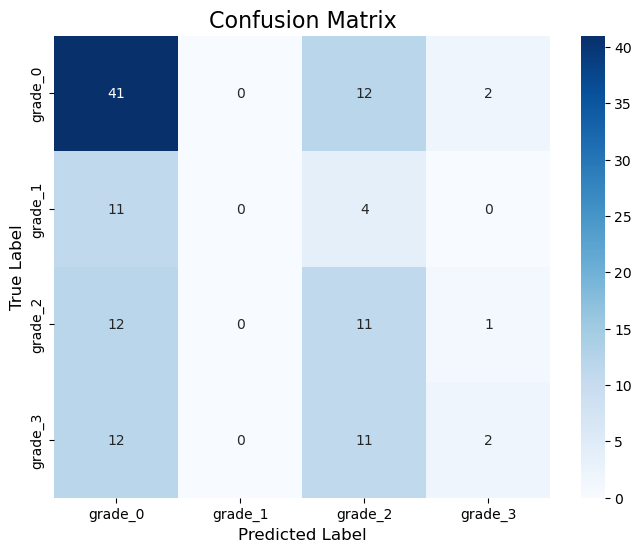

In [14]:
print(f"\n--- Step 7: Evaluating the Best Model ---")
print(f"Loading best model from: {model_filepath}")
best_model = load_model(model_filepath)

# 2. Evaluate its performance (loss and accuracy) on the test set
print("\nEvaluating the final model on the test set...")
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=0)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set Loss: {test_loss:.4f}")

# 3. Generate predictions to create a detailed report and confusion matrix
# First, get the true labels from the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
# Second, get the model's predictions
y_pred_probs = best_model.predict(test_ds)
# Convert prediction probabilities to class labels (0, 1, 2, or 3)
y_pred = np.argmax(y_pred_probs, axis=1)

# 4. Print the Classification Report
print("\nClassification Report:")
# The typo is fixed here:
print(classification_report(y_true, y_pred, target_names=config["class_names"]))

# 5. Create and display the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=config["class_names"], 
            yticklabels=config["class_names"])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
